In [32]:
import importlib
import pickle
import random
from itertools import combinations
from multiprocessing import Pool, cpu_count

import pandas as pd
import matplotlib.pyplot as plt

import utils
importlib.reload(utils)

from utils import (
    logging,
    TARGET_PROTEIN,
    SAMPLE_END_DATE,
    COMBO_MIN_NUM,
    MUTATION_PER_SEQ_FILE,
    FUTURE_COMBO_MISSED_FILE,
    FUTURE_COMBO_MISSED_ID_FILE,
    FUTURE_COMBO_CAPTURED_FILE,
    FUTURE_COMBO_CAPTURED_ID_FILE
)

import utils.miscellaneous
importlib.reload(utils.miscellaneous)

from utils.miscellaneous import area_combo_count


In [2]:
logging.info("Load data")

future_combo_captured: pd.DataFrame = pd.read_feather(
    FUTURE_COMBO_CAPTURED_FILE)
future_combo_captured["Date"] = pd.to_datetime(future_combo_captured["Date"])

with open(FUTURE_COMBO_CAPTURED_ID_FILE, "rb") as f:
    future_combo_captured_id = pickle.load(f)

future_combo_missed: pd.DataFrame = pd.read_feather(FUTURE_COMBO_MISSED_FILE)
future_combo_missed["Date"] = pd.to_datetime(future_combo_missed["Date"])

with open(FUTURE_COMBO_MISSED_ID_FILE, "rb") as f:
    future_combo_missed_id = pickle.load(f)


df: pd.DataFrame = pd.read_feather(MUTATION_PER_SEQ_FILE)

df = df[df["Mutation"].str.contains(TARGET_PROTEIN)]
df = df[~df["Mutation"].str.contains("stop")]
df = df[~df["Mutation"].str.contains("ins")]
df["AA"] = df["Mutation"].str.split("_").str[1].str[1:]

df["Date"] = pd.to_datetime(df["Date"])
future_df: pd.DataFrame = df[df["Date"] >= SAMPLE_END_DATE]
del df


In [3]:
combo_per_date_per_area = {}
area_group: pd.DataFrame
ac_group: pd.DataFrame

for c_date, c_date_group in future_df.groupby("Date", sort=False):
    logging.info(f"{c_date}")
    combo_per_area = {}
    for area, area_group in c_date_group.groupby("Area", sort=False):
        combo_per_ac = []
        for _, ac_group in area_group.groupby("Accession", sort=False):
            muts = ac_group["AA"].values
            if len(muts) >= COMBO_MIN_NUM:
                combo_per_ac.append([
                    combo
                    for combo in combinations(muts, COMBO_MIN_NUM)
                ])
        combo_per_area[area] = combo_per_ac
    combo_per_date_per_area[c_date] = combo_per_area


In [53]:
n_sampled = 10000

sampled_captured_id = random.sample(
    list(future_combo_captured["Combo_id"].unique()),
    k=n_sampled
)
sampled_captured = future_combo_captured[future_combo_captured["Combo_id"].isin(
    sampled_captured_id)]
sampled_captured["Category"] = "Captured"

sampled_missed_id = random.sample(
    list(future_combo_missed["Combo_id"].unique()),
    k=n_sampled
)
sampled_missed = future_combo_missed[future_combo_missed["Combo_id"].isin(
    sampled_missed_id)]
sampled_missed["Category"] = "Missed"


/tmp/ipykernel_850204/4157429595.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sampled_captured["Category"] = "Captured"
/tmp/ipykernel_850204/4157429595.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sampled_missed["Category"] = "Missed"


In [54]:
sampled_to_test = pd.concat([sampled_captured, sampled_missed])

In [79]:
captured_per_date_per_area = []
c_date_group: pd.DataFrame

for c_date, c_date_group in sampled_to_test.groupby("Date"):
    logging.info(f"{c_date}")
    captured_combo = [
        future_combo_captured_id[combo_id]
        for combo_id in c_date_group[c_date_group["Category"] == "Captured"]["Combo_id"].values
    ]
    missed_combo = [
        future_combo_missed_id[combo_id]
        for combo_id in c_date_group[c_date_group["Category"] == "Missed"]["Combo_id"].values
    ]
    # if len(set(captured_combo).difference(future_combo_captured_id.values())):
    #     print("Bad")
    # if len(set(missed_combo).difference(future_combo_missed_id.values())):
    #     print("Bad")
    # for area, combo_per_ac in combo_per_date_per_area[c_date].items():
    #     print(area_combo_count(combo_per_ac, captured_combo, missed_combo, c_date, area))
    # break
    with Pool(cpu_count()) as p:
        captured_per_area = p.starmap(
            func=area_combo_count,
            iterable=((combo_per_ac, captured_combo, missed_combo, c_date, area)
                      for area, combo_per_ac in combo_per_date_per_area[c_date].items())
        )
    captured_per_date_per_area.extend(captured_per_area)

captured_per_date_per_area = pd.DataFrame.from_records(
    captured_per_date_per_area)


In [80]:
captured_per_date_per_area

,Area,Date,AC_captured,AC_missed,AC_total
0,Argentina,2020-05-01,0,0,1
1,Australia,2020-05-01,0,0,0
2,Belgium,2020-05-01,0,0,1
3,Bolivia,2020-05-01,0,0,0
4,Brazil,2020-05-01,0,0,7
...,...,...,...,...,...
36383,USA,2021-10-26,1,0,4
36384,Belgium,2021-10-27,0,1,31
36385,France,2021-10-27,0,0,1
36386,USA,2021-10-27,0,0,1


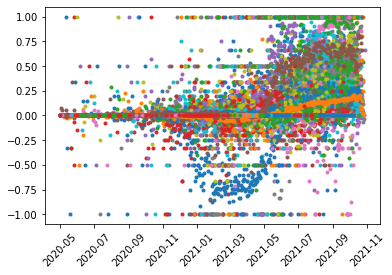

In [82]:
for area, area_group in captured_per_date_per_area.groupby("Area"):
    plt.plot_date(
        area_group["Date"],
        (area_group["AC_captured"] - area_group["AC_missed"]) / area_group["AC_total"],
        fmt="."
    )
    # break
    
_ = plt.xticks(rotation=45)
